# Building a Vector Database from Scratch

This notebook demonstrates the implementation of a simple vector database for semantic search using sentence embeddings. It includes:

1. A `SimpleVectorStore` class that provides basic vector database functionality:
   - Vector storage with L2 normalization
   - Add/get/delete operations
   - Cosine similarity-based search

2. Testing functionality using two different sentence transformer models:
   - `all-MiniLM-L6-v2`: A lightweight, efficient model
   - `all-mpnet-base-v2`: A more powerful but larger model

3. Visualization tools to compare the performance of both models on a simple semantic search task.

The notebook serves as an educational example of:
- How vector databases work internally
- How to implement cosine similarity search
- How different embedding models can affect search results
- Basic vector database operations (CRUD)

Dependencies:
- numpy
- sentence-transformers
- matplotlib

In [2]:
import numpy as np
from typing import List, Tuple
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt


In [3]:

class SimpleVectorStore:
    def __init__(self):
        self.vectors = []  # Stores normalized numpy arrays of embeddings

    def _normalize(self, vector: np.ndarray) -> np.ndarray:
        """
        Normalize a vector to have a magnitude of 1.

        Args:
            vector (np.ndarray): The input vector to normalize.

        Returns:
            np.ndarray: The normalized vector.
        """
        return vector / (np.linalg.norm(vector) + 1e-10)

    def add(self, vector: np.ndarray) -> int:
        """
        Add a pre-normalized vector to the store.

        Args:
            vector (np.ndarray): The embedding vector to store.

        Returns:
            int: The index at which the vector was added.
        """
        norm_vector = self._normalize(vector)
        self.vectors.append(norm_vector)
        return len(self.vectors) - 1

    def get(self, index: int) -> np.ndarray:
        """
        Retrieve a vector by its index.

        Args:
            index (int): The index of the vector.

        Returns:
            np.ndarray: The requested vector.
        """
        if 0 <= index < len(self.vectors):
            return self.vectors[index]
        else:
            raise IndexError("Index out of range.")

    def delete(self, index: int) -> None:
        """
        Delete a vector at the specified index.

        Args:
            index (int): The index of the vector to delete.
        """
        if 0 <= index < len(self.vectors):
            del self.vectors[index]
        else:
            raise IndexError("Index out of range.")

    def query(
        self, query_vector: np.ndarray, top_k: int = 5
    ) -> List[Tuple[int, float]]:
        """
        Query the store for the most similar vectors to the query vector.

        Similarity is measured by cosine similarity.

        Args:
            query_vector (np.ndarray): The vector to compare against stored vectors.
            top_k (int): Number of top similar vectors to return.

        Returns:
            List[Tuple[int, float]]: A list of (index, similarity_score) tuples, sorted by descending similarity.
        """
        if len(self.vectors) == 0:
            return []

        # Normalize the query vector once
        q_norm = self._normalize(query_vector)

        # Calculate cosine similarities
        similarities = []
        for i, vec in enumerate(self.vectors):
            similarity = np.dot(q_norm, vec)
            similarities.append((i, similarity))

        # Sort and return the top-k results
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

In [4]:
def test_models(model_name: str):
    print(f"Testing model: {model_name}")
    model = SentenceTransformer(model_name)
    # Create some example sentences
    sentences = [
        "The cat sits on the mat",
        "A dog runs in the park",
        "Birds fly in the sky",
        "Fish swim in the ocean",
        "The cat chases the mouse",
    ]

    # Create vector store instance
    vector_store = SimpleVectorStore()

    # Convert sentences to embeddings and add them to the store
    embeddings = model.encode(sentences)
    for embedding in embeddings:
        vector_store.add(embedding)

    # Create a query sentence and get its embedding
    query_sentence = "Where is the cat?"
    query_embedding = model.encode([query_sentence])[0]

    # Query the vector store
    results = vector_store.query(query_embedding, top_k=5)

    # Print results
    print("Query:", query_sentence)
    print("Most similar sentences:")
    for idx, score in results:
        print(f"Score: {score:.4f} -> {sentences[idx]}")
    return results

def plot_results(results1, results2):
    """
    Plot similarity scores comparison between two models.

    Args:
        results1: Results from first model (MiniLM-L6-v2)
        results2: Results from second model (mpnet-base-v2)
    """
    # Extract scores from results
    scores1 = [score for _, score in results1]
    scores2 = [score for _, score in results2]

    # Create indices for the bars
    x = np.arange(len(scores1))
    width = 0.35  # Width of the bars

    # Create figure and axis
    plt.figure(figsize=(10, 6))

    # Create bars
    plt.bar(x - width / 2, scores1, width, label="MiniLM-L6-v2", alpha=0.8)
    plt.bar(x + width / 2, scores2, width, label="mpnet-base-v2", alpha=0.8)

    # Customize the plot
    plt.xlabel("Result Index")
    plt.ylabel("Similarity Score")
    plt.title("Similarity Scores Comparison Between Models")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value labels on top of bars
    for i, score in enumerate(scores1):
        plt.text(
            i - width / 2, score, f"{score:.3f}", ha="center", va="bottom", rotation=45
        )
    for i, score in enumerate(scores2):
        plt.text(
            i + width / 2, score, f"{score:.3f}", ha="center", va="bottom", rotation=45
        )

    plt.tight_layout()
    plt.show()

Testing model: sentence-transformers/all-MiniLM-L6-v2
Query: Where is the cat?
Most similar sentences:
Score: 0.5116 -> The cat sits on the mat
Score: 0.4679 -> The cat chases the mouse
Score: 0.1637 -> Birds fly in the sky
Score: 0.1447 -> A dog runs in the park
Score: 0.1423 -> Fish swim in the ocean
Testing model: sentence-transformers/all-mpnet-base-v2
Query: Where is the cat?
Most similar sentences:
Score: 0.4888 -> The cat chases the mouse
Score: 0.3901 -> The cat sits on the mat
Score: 0.1621 -> Fish swim in the ocean
Score: 0.0979 -> Birds fly in the sky
Score: 0.0756 -> A dog runs in the park


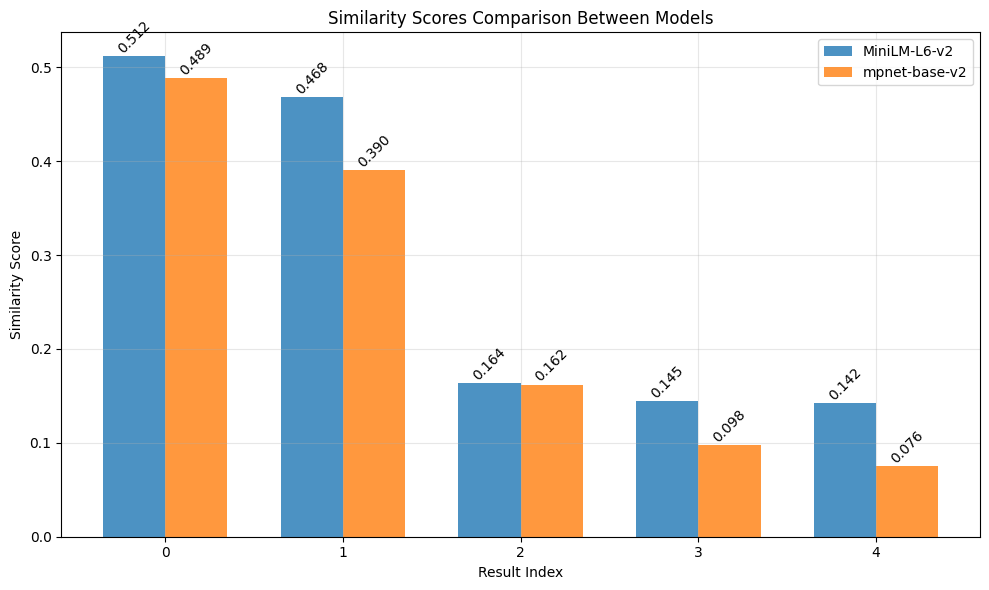

In [5]:
results1 = test_models("sentence-transformers/all-MiniLM-L6-v2")
results2 = test_models("sentence-transformers/all-mpnet-base-v2")
plot_results(results1, results2)
